# Translation from English to kannada using sequence to sequence model

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data and then preprocessing

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase,remove non-letter characters


def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[.!?]+", r" ", s)
    return s

In [4]:

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('dataset_eng_kan.txt',encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 22

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH #and \
        #p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Data preparation

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'kan', False)
print(random.choice(pairs))

Reading lines...
Read 555 sentence pairs
Trimmed to 319 sentence pairs
Counting words...
Counted words:
eng 1450
kan 1770
['european high representative/vice president (hrvp) hjosep borrell fontelles calls on prime minister shri narendra modi', 'ಯುರೋಪ್ ಉನ್ನತ ಪ್ರತಿನಿಧಿ/ ಉಪಾಧ್ಯಕ್ಷ (ಎಚ್ ರ್ ಿ ಿಘನತೆವೆತ್ತ ಜೋಸೆಪ್ ಬೋರೆಲ್ ಫಾಂಟೆಲ್ಸ್ ಅವರಿಂದು ಪ್ರಧಾನಮಂತ್ರಿ ಶ್ರೀ ನರೇಂದ್ರ ಮೋದಿ ಅವರನ್ನು ಭೇಟಿ ಮಾಡಿದರು  ']



# Sequence to Sequence (Seq2Seq) model
## Encoder

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decoder

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

## Attention for Decoder

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training 

## Preparing Training Data

In [10]:
def indexesFromSentence(lang, sentence):
    %matplotlib inline
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Training the model

In [11]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    %matplotlib inline

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### estimated time remaining given the current time and progress in % for training

In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
#train the model with the given no.of iteration and estimation the loss for the training
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    %matplotlib inline
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotting the result of training loss wrt the no.of iteration

In [14]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    %matplotlib inline
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    %matplotlib inline
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


In [27]:
def evaluateRandomly(encoder, decoder, n=50):
    from nltk.translate.bleu_score import sentence_bleu
    %matplotlib inline
    total=0
    average=0
    
    for i in range(n):
        pair = random.choice(pairs)
        print('English: ', pair[0])
        print('Actual: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted: ', output_sentence)
        act = pair[1].split()
        pred = output_sentence.split()
        print('Cumulative 1-gram: %f' % sentence_bleu([act], pred, weights=(1, 0, 0, 0)))
        print('Cumulative 2-gram: %f' % sentence_bleu([act], pred, weights=(0.5, 0.5, 0, 0)))
        print('Cumulative 3-gram: %f' % sentence_bleu([act], pred, weights=(0.33, 0.33, 0.33, 0)))
        print('Cumulative 4-gram: %f' % sentence_bleu([act], pred, weights=(0.25, 0.25, 0.25, 0.25)))
        score = sentence_bleu([act], pred)
        print(score)
        print('')
        total+=score
    average=total/n
    print("Average BLEU score")
    print(average)
    

# Training and  evaluating 

0m 55s (- 12m 0s) (500 7%) 4.9736
1m 39s (- 9m 59s) (1000 14%) 5.1515
2m 23s (- 8m 45s) (1500 21%) 4.5982
3m 4s (- 7m 40s) (2000 28%) 4.2412
3m 48s (- 6m 51s) (2500 35%) 4.2313
4m 33s (- 6m 4s) (3000 42%) 3.9011
5m 19s (- 5m 19s) (3500 50%) 3.4824
6m 6s (- 4m 34s) (4000 57%) 3.0643
6m 52s (- 3m 49s) (4500 64%) 2.5849
7m 17s (- 2m 54s) (5000 71%) 2.0269
7m 39s (- 2m 5s) (5500 78%) 1.6441
8m 5s (- 1m 20s) (6000 85%) 1.1389
8m 29s (- 0m 39s) (6500 92%) 1.0442
8m 53s (- 0m 0s) (7000 100%) 0.6251


<Figure size 432x288 with 0 Axes>

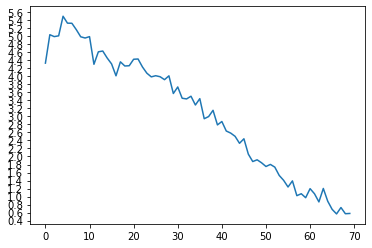

In [19]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 7000, print_every=500)

In [37]:
evaluateRandomly(encoder1, attn_decoder1)

English:  the collaboration between india and sweden in polar science will enable sharing of the expertise available with both countries  
Actual:  ಭಾರತ ಮತ್ತು ಸ್ವೀಡನ್ ನಡುವಿನ ಧ್ರುವ ವಿಜ್ಞಾನದ ಸಹಯೋಗವು ಎರಡೂ ದೇಶಗಳು ಲಭ್ಯವಿರುವ ಪರಿಣತಿಯನ್ನು ಪರಸ್ಪರ ಹಂಚಿಕೊಳ್ಳಲು ಅನುವು ಮಾಡಿಕೊಡುತ್ತದೆ  
Predicted:  ಭಾರತ ಮತ್ತು ಸ್ವೀಡನ್ ನಡುವಿನ ಧ್ರುವ ವಿಜ್ಞಾನದ ಸಹಯೋಗವು ಎರಡೂ ದೇಶಗಳು ಲಭ್ಯವಿರುವ ಪರಿಣತಿಯನ್ನು ಪರಸ್ಪರ ಹಂಚಿಕೊಳ್ಳಲು ಅನುವು ಮಾಡಿಕೊಡುತ್ತದೆ   
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

English:  first, to reinforce indias ancient culture of giving importance to every individuals duties and obligations  
Actual:  ಮೊದಲನೆಯದಾಗಿ, ಪ್ರತಿಯೊಬ್ಬ ವ್ಯಕ್ತಿಯ ಕರ್ತವ್ಯಗಳು ಮತ್ತು ಕಟ್ಟುಪಾಡುಗಳಿಗೆ ಪ್ರಾಮುಖ್ಯತೆ ನೀಡುವ ಭಾರತದ ಪ್ರಾಚೀನ ಸಂಸ್ಕೃತಿಯನ್ನು ಪುನಶ್ಚೈತನ್ಯಗೊಳಿಸಿ  
Predicted:  ಮೊದಲನೆಯದಾಗಿ, ಪ್ರತಿಯೊಬ್ಬ ವ್ಯಕ್ತಿಯ ಕರ್ತವ್ಯಗಳು ಮತ್ತು ಕಟ್ಟುಪಾಡುಗಳಿಗೆ ಪ್ರಾಮುಖ್ಯತೆ ಭಾರತದ ಪ್ರಾಚೀನ ಸಂಸ್ಕೃತಿಯನ್ನು ಪುನಶ್ಚೈತನ್ಯಗೊಳಿಸಿ   
Cumulative 1-gram: 0.913101
Cumulative 2-gram: 0.866243
Cumulative 3-gram: 0

# Visualizing attention

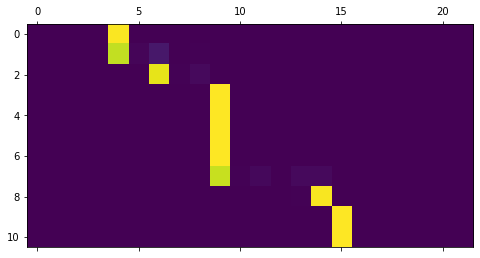

In [21]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "you do your ")
plt.matshow(attentions.numpy())

In [22]:
def showAttention(input_sentence, output_words, attentions):
    %matplotlib inline
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = pm visit karnataka on 2nd and 3rd january 2020
output = 2020ರ ಜನವರಿ 2 ಮತ್ತು 3ರಂದು ಕರ್ನಾಟಕಕ್ಕೆ ಪ್ರಧಾನಮಂತ್ರಿ ಭೇಟಿ 


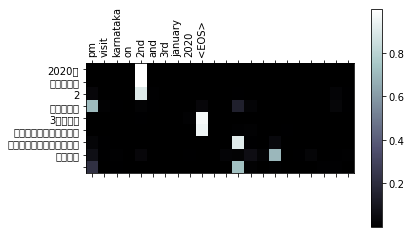

In [24]:



evaluateAndShowAttention("pm visit karnataka on 2nd and 3rd january 2020")
